In [63]:
# importamos las librerias que vamos a utilizar en el notebook

import torch # libreria principal
import torch.nn as nn # libreria para redes neuronales
import torch.optim as optim # libreria para optimizacion
from torch.utils.data import DataLoader, Dataset # libreria para cargar los datos
import torchvision.transforms as transforms # libreria para transformar los datos
from torchvision import models # libreria para modelos pre-entrenados
from datasets import load_dataset # libreria para cargar los datos

In [64]:
# cargamos el dataset de Tiny ImageNet y lo guardamos en la variable dataset
dataset_tiny_img = load_dataset("zh-plus/tiny-imagenet")

In [65]:
# mostramos la estructura del dataset
dataset_tiny_img

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [66]:
dataset_tiny_img['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64>,
 'label': 0}

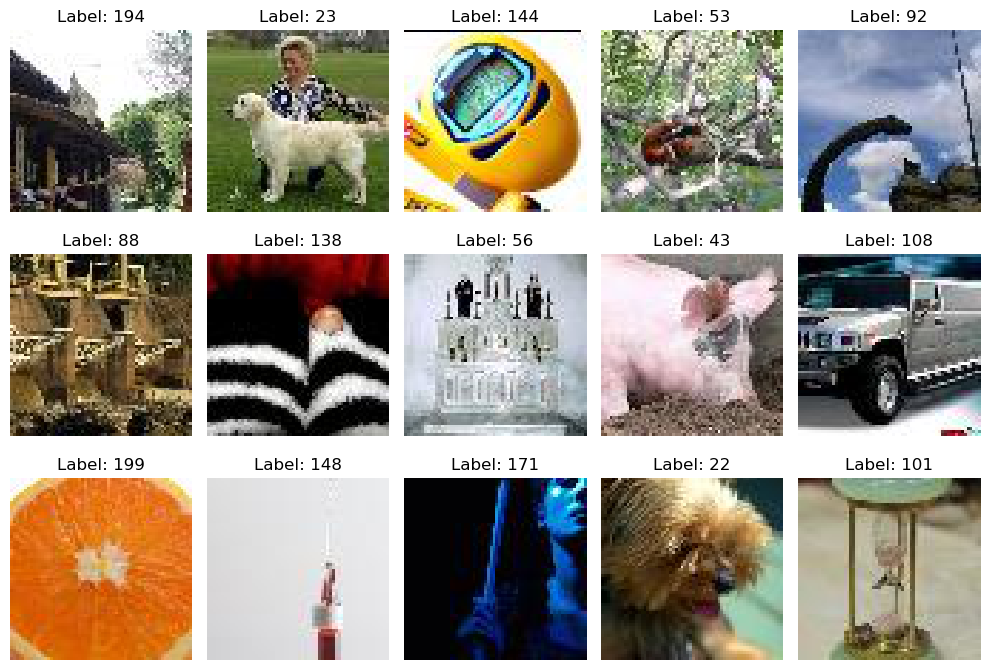

In [68]:
# graficamos algunas imagenes para saber con que tipo de datos estamos trabajando
import matplotlib.pyplot as plt
import random

# Configurar la tabla como 3 filas y 5 columnas
num_rows = 3
num_columns = 5

# Crear una figura y ejes para la tabla de imágenes
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 7))

for i in range(num_rows):
    for j in range(num_columns):
        # Elegir aleatoriamente una imagen del conjunto de entrenamiento
        random_index = random.randint(0, len(dataset_tiny_img['train']) - 1)
        random_image = dataset_tiny_img['train'][random_index]['image']
        random_label = dataset_tiny_img['train'][random_index]['label']

        # Mostrar la imagen en el subgráfico correspondiente
        axes[i, j].imshow(random_image, interpolation='nearest')
        axes[i, j].set_title(f"Label: {random_label}")
        axes[i, j].axis('off')  # Ocultar los ejes
# Ajustar el espacio entre los subgráficos para que se vean bien
plt.tight_layout()
# Mostrar la tabla de imágenes
plt.show()

In [69]:
# Definir una transformación para el preprocesamiento de imágenes.
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # pasar a escala de grises (3 canales)
    transforms.Resize((64, 64)), # redimensionar a 64x64
    transforms.ToTensor(), # convertir a tensor
    # normalizar las imagenes con valores entre 0 y 1 (en vez de 0 y 255)
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [70]:
# Defina su clase de conjunto de datos personalizado
class CustomDataset(Dataset):
    def __init__(self, dataset, split, transform=None):
        self.X = dataset[split]['image'] # cargar imágenes
        self.y = dataset[split]['label'] # cargar etiquetas
        self.transform = transform

    # Devuelve el número de muestras en el conjunto de datos.
    def __len__(self):
        return len(self.X)

    # Devuelve una muestra del conjunto de datos en la posición index.
    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [71]:
# Creamos el conjunto de datos de entrenamiento y de prueba con la clase CustomDataset que definimos anteriormente 
dataset = {
    'train' : CustomDataset(dataset_tiny_img, 'train', transform=transform),
    'test' : CustomDataset(dataset_tiny_img, 'valid', transform=transform),
}

len(dataset['train']), len(dataset['test'])

(100000, 10000)

In [72]:
dataset['train'][2]

(tensor([[[-0.0353, -0.2784, -0.3490,  ..., -0.2235,  0.1608, -0.1137],
          [-0.3020, -0.0275, -0.3412,  ...,  0.1216,  0.0353, -0.0588],
          [-0.6078, -0.4275, -0.4980,  ...,  0.7020, -0.1451,  0.0039],
          ...,
          [ 0.5373,  0.4118,  0.4039,  ...,  0.8196,  0.8039,  0.7961],
          [ 0.3490,  0.3020,  0.3176,  ...,  0.8039,  0.7882,  0.7804],
          [ 0.2314,  0.3725,  0.3725,  ...,  0.7725,  0.7569,  0.7490]],
 
         [[-0.0353, -0.2784, -0.3490,  ..., -0.2235,  0.1608, -0.1137],
          [-0.3020, -0.0275, -0.3412,  ...,  0.1216,  0.0353, -0.0588],
          [-0.6078, -0.4275, -0.4980,  ...,  0.7020, -0.1451,  0.0039],
          ...,
          [ 0.5373,  0.4118,  0.4039,  ...,  0.8196,  0.8039,  0.7961],
          [ 0.3490,  0.3020,  0.3176,  ...,  0.8039,  0.7882,  0.7804],
          [ 0.2314,  0.3725,  0.3725,  ...,  0.7725,  0.7569,  0.7490]],
 
         [[-0.0353, -0.2784, -0.3490,  ..., -0.2235,  0.1608, -0.1137],
          [-0.3020, -0.0275,

In [73]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 64, 64])

In [74]:
# Cargar el modelo preentrenado resnext50_32x4d
model = models.resnext50_32x4d(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [75]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=200, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnext
    resnext = models.resnext50_32x4d(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnext = nn.Sequential(*list(resnext.children())[:-1])
    if freeze:
      for param in self.resnext.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = nn.Linear(2048, 200)

  def forward(self, x):
    x = self.resnext(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnext.parameters():
        param.requires_grad=True

In [76]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 200])

In [77]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [56]:
# Entrenando desde Cero (Sin Transfer Learning)
model_c = ModelCustom()
fit(model_c, dataloader, epochs=1)

val_loss 5.13652 val_acc 0.02187: 100%|██████████| 40/40 [00:05<00:00,  7.35it/s]

Epoch 1/1 loss 5.30341 val_loss 5.13652 acc 0.01177 val_acc 0.02187


In [80]:
# Entrenando con Transfer Learning, entrenando solo la capa de salida (fc)
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

val_loss 13.78367 val_acc 0.15088: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s]


Epoch 1/5 loss 12.13960 val_loss 13.78367 acc 0.12985 val_acc 0.15088


val_loss 14.09656 val_acc 0.16436: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s]


Epoch 2/5 loss 12.67015 val_loss 14.09656 acc 0.17258 val_acc 0.16436


val_loss 15.52124 val_acc 0.15762: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s]


Epoch 3/5 loss 12.59941 val_loss 15.52124 acc 0.18926 val_acc 0.15762


val_loss 15.49951 val_acc 0.16855: 100%|██████████| 40/40 [00:05<00:00,  7.08it/s]


Epoch 4/5 loss 12.52013 val_loss 15.49951 acc 0.20409 val_acc 0.16855


val_loss 16.70231 val_acc 0.16738: 100%|██████████| 40/40 [00:05<00:00,  7.26it/s]

Epoch 5/5 loss 12.53877 val_loss 16.70231 acc 0.21548 val_acc 0.16738


In [58]:
# Entrenando con finetuning, entrenando todas las capas pero con los pesos preentrenados
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 2.08310 val_acc 0.48887: 100%|██████████| 40/40 [00:05<00:00,  7.49it/s]


Epoch 1/5 loss 3.08469 val_loss 2.08310 acc 0.33516 val_acc 0.48887


val_loss 1.83684 val_acc 0.55068: 100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


Epoch 2/5 loss 1.76396 val_loss 1.83684 acc 0.56485 val_acc 0.55068


val_loss 1.86278 val_acc 0.54678: 100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


Epoch 3/5 loss 1.24819 val_loss 1.86278 acc 0.68240 val_acc 0.54678


val_loss 1.93963 val_acc 0.54873: 100%|██████████| 40/40 [00:05<00:00,  7.51it/s]


Epoch 4/5 loss 0.85769 val_loss 1.93963 acc 0.77824 val_acc 0.54873


val_loss 2.01323 val_acc 0.54609: 100%|██████████| 40/40 [00:05<00:00,  7.56it/s]

Epoch 5/5 loss 0.55792 val_loss 2.01323 acc 0.85609 val_acc 0.54609


In [59]:
# Entrenando con finetuning (Congelando y Descongelando), entrenamos solo la capa de salida (fc) y luego todas las capas
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

val_loss 4.10486 val_acc 0.19717: 100%|██████████| 40/40 [00:05<00:00,  7.11it/s]


Epoch 1/5 loss 4.62197 val_loss 4.10486 acc 0.12815 val_acc 0.19717


val_loss 3.76697 val_acc 0.22695: 100%|██████████| 40/40 [00:05<00:00,  7.49it/s]


Epoch 2/5 loss 3.88012 val_loss 3.76697 acc 0.22620 val_acc 0.22695


val_loss 3.67201 val_acc 0.23770: 100%|██████████| 40/40 [00:05<00:00,  7.50it/s]


Epoch 3/5 loss 3.62072 val_loss 3.67201 acc 0.25285 val_acc 0.23770


val_loss 3.59808 val_acc 0.24971: 100%|██████████| 40/40 [00:05<00:00,  7.50it/s]


Epoch 4/5 loss 3.49195 val_loss 3.59808 acc 0.26722 val_acc 0.24971


val_loss 3.54099 val_acc 0.25186: 100%|██████████| 40/40 [00:06<00:00,  6.21it/s]


Epoch 5/5 loss 3.40243 val_loss 3.54099 acc 0.27648 val_acc 0.25186


val_loss 3.08111 val_acc 0.32305: 100%|██████████| 40/40 [00:06<00:00,  5.97it/s]


Epoch 1/5 loss 3.08967 val_loss 3.08111 acc 0.32374 val_acc 0.32305


val_loss 2.90021 val_acc 0.34961: 100%|██████████| 40/40 [00:05<00:00,  7.35it/s]


Epoch 2/5 loss 2.82633 val_loss 2.90021 acc 0.36319 val_acc 0.34961


val_loss 2.78872 val_acc 0.36572: 100%|██████████| 40/40 [00:05<00:00,  7.12it/s]


Epoch 3/5 loss 2.68955 val_loss 2.78872 acc 0.38443 val_acc 0.36572


val_loss 2.71217 val_acc 0.37441: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s]


Epoch 4/5 loss 2.59337 val_loss 2.71217 acc 0.40030 val_acc 0.37441


val_loss 2.64675 val_acc 0.38545: 100%|██████████| 40/40 [00:05<00:00,  7.33it/s]

Epoch 5/5 loss 2.51201 val_loss 2.64675 acc 0.41578 val_acc 0.38545


In [90]:
optimizer = torch.optim.Adam([
    {'params': model_o.resnext.parameters(), 'lr': 1e-4},
    {'params': model_o.fc.parameters(), 'lr': 1e-3}
])

In [91]:
from tqdm import tqdm
import numpy as np

def fit1(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam([{'params': model.resnext.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [92]:
model_o = ModelCustom(pretrained=True, freeze=False)
fit1(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

val_loss 2.18453 val_acc 0.48740: 100%|██████████| 40/40 [00:05<00:00,  7.36it/s]


Epoch 1/5 loss 2.70247 val_loss 2.18453 acc 0.38606 val_acc 0.48740


val_loss 2.14394 val_acc 0.50840: 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


Epoch 2/5 loss 1.67746 val_loss 2.14394 acc 0.58354 val_acc 0.50840


val_loss 2.27156 val_acc 0.51016: 100%|██████████| 40/40 [00:05<00:00,  7.34it/s]


Epoch 3/5 loss 1.13553 val_loss 2.27156 acc 0.70137 val_acc 0.51016


val_loss 2.63860 val_acc 0.49609: 100%|██████████| 40/40 [00:05<00:00,  7.39it/s]


Epoch 4/5 loss 0.76612 val_loss 2.63860 acc 0.79024 val_acc 0.49609


val_loss 2.85223 val_acc 0.49893: 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]

Epoch 5/5 loss 0.55220 val_loss 2.85223 acc 0.84202 val_acc 0.49893
